# 0.0 Importing Essentials

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from typing import Tuple
plt.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1.0 Exploring Data

In [2]:
df = pd.read_csv(r'/content/jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
df['Date Time'] = pd.to_datetime(df['Date Time'], format="%d.%m.%Y %H:%M:%S")
df.set_index(df['Date Time'], inplace=True)
df = df.drop('Date Time', axis=1)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


In [5]:
df['wv (m/s)'] = df['wv (m/s)'].replace(to_replace=-9999.0, value=0.0)
df['max. wv (m/s)'] = df['max. wv (m/s)'].replace(to_replace=-9999.0, value=0.0)
print('New min of wv : {}\nNew min of max wv : {}'.format(df['wv (m/s)'].min(), df['max. wv (m/s)'].min()))

New min of wv : 0.0
New min of max wv : 0.0


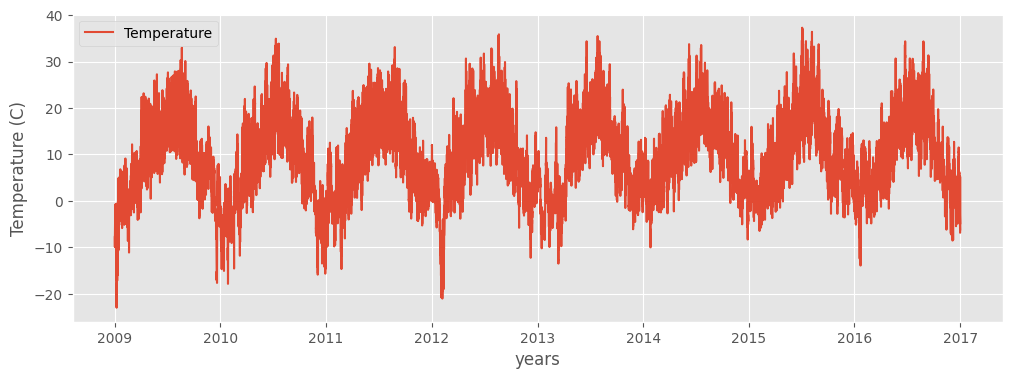

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['T (degC)'], label='Temperature')
plt.xlabel('years')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show();

# 2.0 Train and Test Data Split

*Important point:*
- Only a subset of features are used for simplicity.
- Hourly data for a year is taken for train and test split instead of per 10 mins measured in dataset.

In [7]:
features = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
yearly_sample = 365.25 * 24 * 6


train_data = df[features][:int(yearly_sample * 2):6].to_numpy()
test_data = df[features][int(yearly_sample*2) : int(yearly_sample * 4):6].to_numpy()
print(f'Train Data Shape : {train_data.shape}\nTest Data shape : {test_data.shape}')

Train Data Shape : (17532, 3)
Test Data shape : (17532, 3)


## 2.1 Visualising Splitted Data

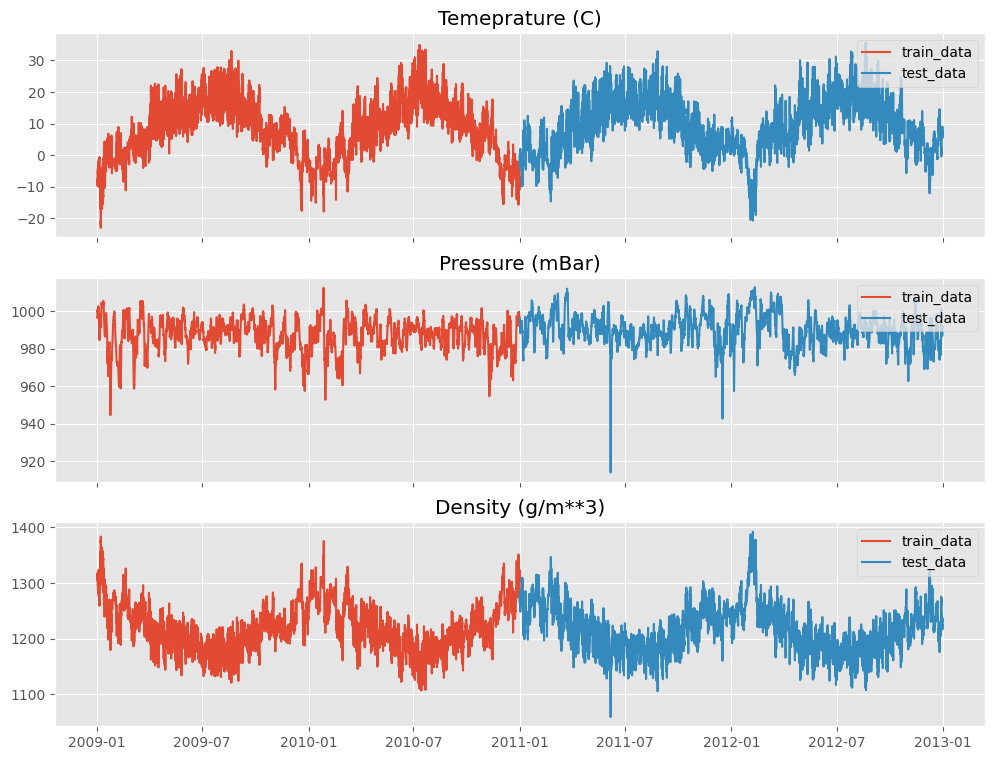

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), sharex=True)
titles = ['Temeprature (C)', 'Pressure (mBar)', 'Density (g/m**3)']

for i in range(3):
    axs[i].plot(df.index[:int(yearly_sample*2):6], train_data[:,i], label='train_data')
    axs[i].plot(df.index[int(yearly_sample*2):int(yearly_sample*4):6], test_data[:,i], label = 'test_data')
    axs[i].legend(loc="upper right")
    axs[i].set_title(titles[i])
plt.show()

# 3.0 Utilities

## 3.1 Standard Scaler

In [9]:
class StandardScaler:
    def fit(self, x: np.ndarray, axis:int):
        self.mean = np.mean(x, axis=axis)
        self.std = np.std(x, axis=axis)

    def transform(self, x: np.ndarray) -> np.ndarray:
        return (x - self.mean) / self.std

    def inverse_transform(self, x: np.ndarray) -> np.ndarray:
        return x * self.std + self.mean

scaler = StandardScaler()
scaler.fit(train_data, axis=0)
sc_data = scaler.transform(train_data)
print(f'Mean values of features : {scaler.mean}\nStandard deviation values of features : {scaler.std}')

Mean values of features : [   8.17252453  987.38820386 1219.70650867]
Standard deviation values of features : [ 9.03325185  8.52346058 41.73386411]


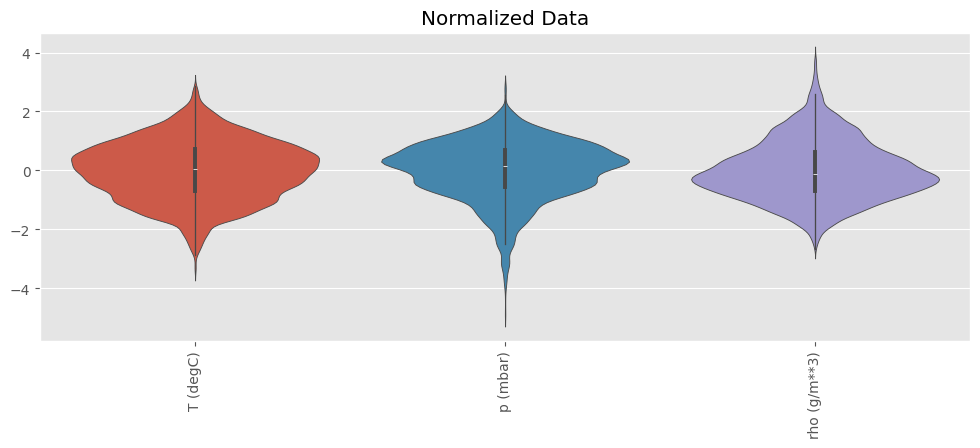

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (12, 4), sharex=True)

sns.violinplot(data=sc_data, ax=axs)
axs.xaxis.set_ticks(np.arange(0, train_data.shape[-1]))
axs.xaxis.set_ticklabels(features, rotation=90)
axs.set_title('Normalized Data')
plt.show();

## 3.2 Custom Dataset

In [11]:
class CustomDataset(Dataset):
    def __init__(
            self,
            data: np.ndarray,
            in_seq_len: int,
            out_seq_len: int,
            offset :int,
            in_features: slice | int,
            out_features: slice | int,
            scaler,
            ):
        super().__init__()
        self.data = data
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.offset = offset
        self.in_features = in_features
        self.out_features = out_features
        self.scaler = scaler

        if self.in_seq_len > self.offset + self.out_seq_len:
            raise ValueError('Invalid input ouput mapping provided')

    def __len__(self) -> int:
        return len(self.data) - self.in_seq_len - self.offset

    def __getitem__(self, index:int) -> Tuple[torch.Tensor,torch.Tensor]:
        data = self.data[index : index + self.in_seq_len + self.offset]
        data = self.scaler.transform(data)
        x = torch.tensor(data[:self.in_seq_len, self.in_features], dtype=torch.float32)
        y = torch.tensor(data[self.offset: self.offset + self.out_seq_len, self.out_features], dtype=torch.float32)

        if x.ndim == 1:
            x = x.view(-1, 1)
        if y.ndim == 1:
            y = y.view(-1, 1)
        return x, y

dataset = CustomDataset(train_data, in_seq_len=24, out_seq_len=24, offset=24, in_features=0, out_features=0, scaler=scaler)
print(f'Input shape : {dataset[0][0].shape}\nLabel shape : {dataset[0][1].shape}')

Input shape : torch.Size([24, 1])
Label shape : torch.Size([24, 1])


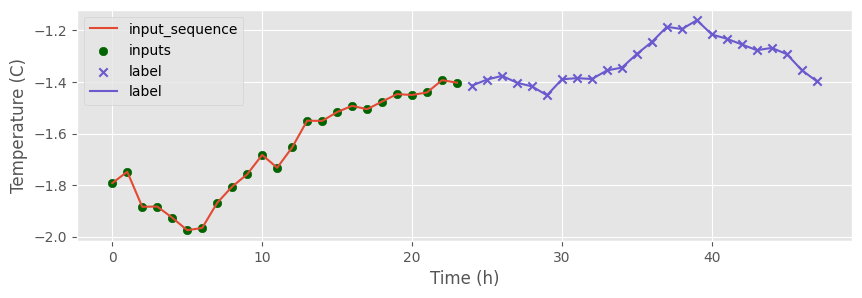

In [12]:
plt.figure(figsize=(10, 3))
plt.plot(range(0, 24), dataset[0][0].numpy(), label='input_sequence')
plt.scatter(range(0, 24), dataset[0][0].numpy(), label='inputs', color='darkgreen')
plt.scatter(range(24, 48), dataset[0][1].numpy(), color='slateblue', label = 'label',marker='x')
plt.plot(range(24, 48), dataset[0][1].numpy(), color='slateblue', label = 'label')
plt.xlabel('Time (h)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show();

## 3.3 Training Pipeline

In [23]:
class Trainer:
    def __init__(
            self,
            model: nn.Module,
            optimizer: torch.optim.Optimizer,
            dataset: Dataset,
            batch_size:int,
            epochs:int
            ):
        self.model = model
        self.optimizer = optimizer
        self.dataset = dataset
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = next(self.model.parameters()).device

    def get_dataloader(self, split:str) -> DataLoader:
        train_dataset, val_dataset = random_split(self.dataset, [0.8, 0.2])
        if split == 'train':
            return DataLoader(train_dataset, self.batch_size, True, drop_last=True)
        elif split == 'val':
            return DataLoader(val_dataset, self.batch_size, False, drop_last=True)

    def train_model(self) -> np.ndarray:
        hx = self.model._init_state(self.batch_size)
        loader = self.get_dataloader('train')
        total_loss = []
        self.model.train()
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            y_pred, hx = self.model(x, hx)
            hx = hx.detach()
            loss = F.mse_loss(y, y_pred)
            loss.backward()
            self.optimizer.step()
            total_loss.append(loss.detach().cpu().numpy())
        return np.mean(total_loss)

    def eval_model(self) -> np.ndarray:
        loader = self.get_dataloader('val')
        total_loss = []
        self.model.eval()
        hx = self.model._init_state(self.batch_size)
        for x, y in loader:
            with torch.no_grad():
                x, y = x.to(self.device), y.to(self.device)
                self.model.eval()
                y_pred, hx = self.model(x, hx)
                loss = F.mse_loss(y, y_pred)
                total_loss.append(loss.detach().cpu().numpy())
        return np.mean(total_loss)

    def train(self):
        for epoch in tqdm(range(self.epochs)):
            train_loss = self.train_model()
            val_loss = self.eval_model()

            if epoch % (self.epochs /10) == 0:
                gpu_usage = round(torch.cuda.memory_reserved(0)/1024**3,1)
                print(f'Epochs : {epoch} | train loss : {train_loss:.4f} | val loss : {val_loss:.4f} | gpu usage : {gpu_usage}')

## 3.4 Inference Pipeline

In [14]:
class Inference:
    def __init__(
        self,
        model: nn.Module,
        data: np.ndarray,
        scaler,
        in_seq_len: int,
        out_seq_len: int,
        offset: int,
        in_feats: slice | int,
        out_feats: slice | int,
        prediction_style: str,
        ):
        self.model = model
        self.data = data
        self.scaler = scaler
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.offset = offset
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.prediction_style = prediction_style
        self.device = next(self.model.parameters()).device

    def get_random_sample(self)->torch.Tensor:
        self.idx = np.random.randint(len(self.data) - self.in_seq_len - self.offset)
        x = self.data[self.idx : self.idx + self.in_seq_len, self.in_feats]
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype = torch.float32, device = self.device)
        if x.ndim == 1:
            x = x.unsqueeze(0).unsqueeze(-1)
        elif x.ndim == 2:
            x = x.unsqueeze(0)
        return x

    def ar_generation(self, x:torch.Tensor, hx:torch.Tensor)->torch.Tensor:
        for _ in range(self.out_seq_len):
            x_trunc = x[:, -self.out_seq_len:, :]
            y_pred, hx = self.model(x_trunc, hx)
            x = torch.cat((x_trunc, y_pred), dim=1)
        return x[:,-self.out_seq_len:, :]

    def predict(self)->np.ndarray:
        x = self.get_random_sample()
        self.model.eval()
        with torch.inference_mode():
            hx = self.model._init_state(x.shape[0])
            if self.prediction_style == 'zs':
                y_pred, _ = self.model(x, hx)
            elif self.prediction_style == 'ar':
                y_pred = self.ar_generation(x, hx)
        y_pred = self.scaler.inverse_transform(y_pred.cpu().detach().numpy())[:, :,self.out_feats]
        return y_pred.reshape(-1)

    def plot(self, **title):
        y_pred = self.predict()

        x = self.data[self.idx : self.idx + self.in_seq_len,self.out_feats]
        y = self.data[self.idx + self.in_seq_len : self.idx + self.in_seq_len + self.out_seq_len, self.out_feats]
        plt.figure(figsize=(12, 5))

        if len(x) == 1:
            plt.scatter(range(0, self.in_seq_len), x, label='inputs', color='darkgreen')
        else:
            plt.plot(range(0, self.in_seq_len), x, label='inputs', color='darkgreen')
            plt.plot(range(self.in_seq_len, self.in_seq_len+ self.out_seq_len), y, label = 'true')
            plt.plot(range(self.in_seq_len, self.in_seq_len + self.out_seq_len), y_pred, color='slateblue', label ='predictions')

        plt.scatter(range(self.in_seq_len, self.in_seq_len+ self.out_seq_len), y, edgecolors='black', label = 'true')
        plt.scatter(range(self.in_seq_len, self.in_seq_len + self.out_seq_len), y_pred, marker='X', edgecolors='black', color='slateblue', label ='predictions')
        plt.legend()
        plt.xlabel('Time (h)')
        plt.ylabel('Temeprature (C)')

        title = title.get('title')
        if title is not None:
            plt.title(title)
        plt.show()

    def test_model(self, data: np.ndarray, batch_size:int, in_feats: slice | int, out_feats: slice | int) -> np.ndarray:
        dataset = CustomDataset(data, self.in_seq_len, self.out_seq_len, self.offset, in_feats, out_feats, self.scaler)
        dataloader = DataLoader(dataset, batch_size, drop_last=True)
        total_loss = []
        hx = self.model._init_state(batch_size)
        self.model.eval()
        with torch.inference_mode():
            for x, y in dataloader:
                x, y = x.to(self.device), y.to(self.device)
                y_pred , hx = self.model(x, hx)
                loss = F.mse_loss(y_pred, y)
                total_loss.append(loss.cpu().detach().numpy())
        return np.mean(total_loss)

# 4.0 Modelling

In [15]:
performance_log = {'baseline':[],'siso':[], 'miso':[], 'mimo_zs': [], 'mimo_ar': []}

Baseline model predicts next day's prediction as the previous days temperature values sicne, it is logical to assume that the deviation in tempeature pattern with subsequent days would not be drastic.

## 4.1 Baseline Model

In [16]:
def test_base_model(data, in_seq_len, out_seq_len, offset, in_feats, out_feats, scaler, batch_size):
    dataset = CustomDataset(data, in_seq_len, out_seq_len, offset, in_feats, out_feats, scaler)
    dataloader = DataLoader(dataset, batch_size)
    total_loss = []
    with torch.inference_mode():
        for x, y in dataloader:
            loss = F.mse_loss(y, x)
            total_loss.append(loss.numpy())
    return np.mean(total_loss)

loss = test_base_model(test_data, 24, 24, 24, 0, 0, scaler, 32)
performance_log['baseline'].append(loss)
print(loss)

0.15699112


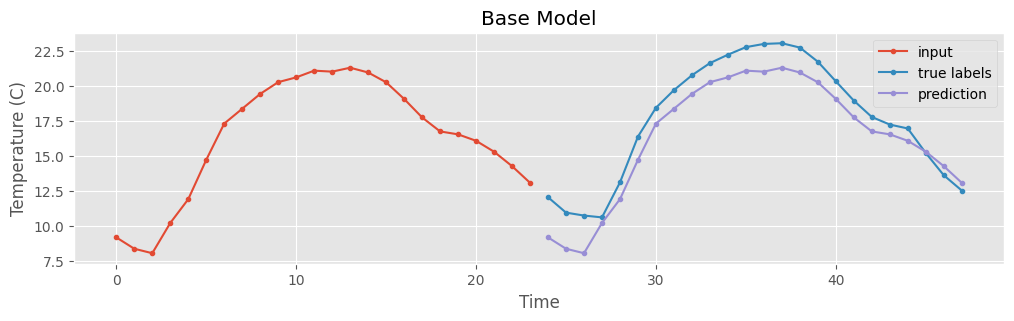

In [17]:
def baseline_gen(data, in_seq_len, out_seq_len, offset):
    idx = np.random.randint(0, len(data)- in_seq_len - offset)
    x = data[idx : idx + in_seq_len]
    y = data[idx + offset : idx + offset + in_seq_len]
    plt.figure(figsize=(12, 3))
    plt.plot(range(0, in_seq_len), x, marker='.', label='input')
    plt.plot(range(offset, offset + out_seq_len), y, marker='.', label='true labels')
    plt.plot(range(offset, offset + out_seq_len), x, marker='.',  label='prediction')
    plt.title('Base Model')
    plt.xlabel('Time')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show();

baseline_gen(test_data[:,0], 24, 24, 24)

## 4.2 GRU Model

In [18]:
class GRUModel(nn.Module):
    def __init__(self, input_features:int, hidden_dim:int, output_features:int, num_layers:int, dropout:float, out_seq_len:int):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_features, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.ffwd = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Linear(hidden_dim * 2, output_features)
        )

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.out_seq_len = out_seq_len

    def forward(self, x, hx):
        if hx.device != x.device:
            hx = hx.to(x.device)
        x, hx = self.gru(x, hx)
        x = self.dropout(x)
        x = self.ffwd(x)
        if self.out_seq_len == 1:
            x = x[:,-1, :].unsqueeze(1)
        elif self.out_seq_len < x.shape[1]:
            x = x[:,-self.out_seq_len,:]
        return x, hx

    def _init_state(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)

## 4.3 Single Output models

### 4.3.1 Single Step Input - Single Step Output

This model tries to find correlation in successive values, and not on a long term basis.

In [19]:
dataset = CustomDataset(train_data, in_seq_len=1, out_seq_len=1, offset=1, in_features=slice(0,3), out_features=0, scaler = scaler)
print(f'Input shape : {dataset[0][0].shape}\nLabel shape : {dataset[0][1].shape}')

Input shape : torch.Size([1, 3])
Label shape : torch.Size([1, 1])


In [20]:
model = GRUModel(input_features=3, hidden_dim=64, output_features=1, num_layers=1, dropout=0.1, out_seq_len=1)
hx = model._init_state(1)
print(f'prediction shape: {model(dataset[0][0].unsqueeze(0), hx)[0].shape}',
      f'\nlabel shape: {dataset[0][1].unsqueeze(0).shape}')
print(f'num parameters : {sum(p.numel() for p in model.parameters())}')

prediction shape: torch.Size([1, 1, 1]) 
label shape: torch.Size([1, 1, 1])
num parameters : 21697


In [21]:
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [24]:
trainer = Trainer(model, optimizer, dataset, batch_size=64, epochs=10)
trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs : 0 | train loss : 0.0175 | val loss : 0.0141 | gpu usage : 0.0
Epochs : 1 | train loss : 0.0166 | val loss : 0.0132 | gpu usage : 0.0
Epochs : 2 | train loss : 0.0159 | val loss : 0.0123 | gpu usage : 0.0
Epochs : 3 | train loss : 0.0158 | val loss : 0.0134 | gpu usage : 0.0
Epochs : 4 | train loss : 0.0156 | val loss : 0.0127 | gpu usage : 0.0
Epochs : 5 | train loss : 0.0153 | val loss : 0.0127 | gpu usage : 0.0
Epochs : 6 | train loss : 0.0151 | val loss : 0.0133 | gpu usage : 0.0
Epochs : 7 | train loss : 0.0151 | val loss : 0.0121 | gpu usage : 0.0
Epochs : 8 | train loss : 0.0150 | val loss : 0.0132 | gpu usage : 0.0
Epochs : 9 | train loss : 0.0150 | val loss : 0.0121 | gpu usage : 0.0


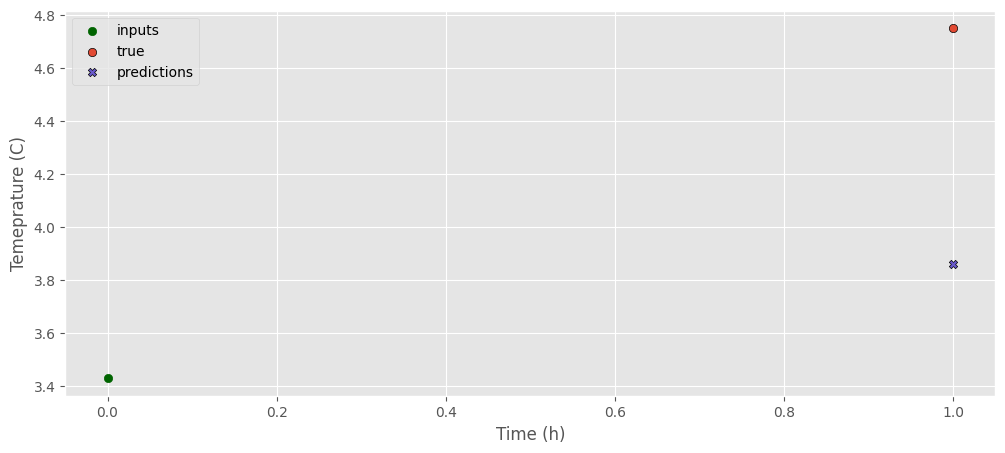

In [25]:
inference = Inference(model, test_data, scaler, in_seq_len=1, out_seq_len=1, offset=1, in_feats=slice(0, 3), out_feats=0, prediction_style='zs')
inference.plot()

In [26]:
test_loss = inference.test_model(test_data, 32, in_feats=slice(0, 3), out_feats=0)
performance_log['siso'].append(test_loss)
print(f'Test Loss : {test_loss}')

Test Loss : 0.014234540052711964


In [27]:
del model

### 4.3.2 Multi Step Input - Single Step Output

In [28]:
dataset = CustomDataset(train_data, in_seq_len=24, out_seq_len=1, offset=24, in_features=slice(0,3), out_features=0, scaler = scaler)
print(f'Input shape : {dataset[0][0].shape}\nLabel shape : {dataset[0][1].shape}')

Input shape : torch.Size([24, 3])
Label shape : torch.Size([1, 1])


In [29]:
model = GRUModel(input_features=3, hidden_dim=64, output_features=1, num_layers=1, dropout=0.1, out_seq_len=1)
hx = model._init_state(1)
print(f'prediction shape: {model(dataset[0][0].unsqueeze(0), hx)[0].shape}',
      f'\nlabel shape: {dataset[0][1].unsqueeze(0).shape}')
print(f'num parameters : {sum(p.numel() for p in model.parameters())}')

prediction shape: torch.Size([1, 1, 1]) 
label shape: torch.Size([1, 1, 1])
num parameters : 21697


In [30]:
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [31]:
trainer = Trainer(model, optimizer, dataset, batch_size=64, epochs=10)
trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs : 0 | train loss : 0.1976 | val loss : 0.0375 | gpu usage : 0.0
Epochs : 1 | train loss : 0.0287 | val loss : 0.0163 | gpu usage : 0.0
Epochs : 2 | train loss : 0.0169 | val loss : 0.0107 | gpu usage : 0.0
Epochs : 3 | train loss : 0.0141 | val loss : 0.0087 | gpu usage : 0.0
Epochs : 4 | train loss : 0.0129 | val loss : 0.0090 | gpu usage : 0.0
Epochs : 5 | train loss : 0.0120 | val loss : 0.0084 | gpu usage : 0.0
Epochs : 6 | train loss : 0.0113 | val loss : 0.0079 | gpu usage : 0.0
Epochs : 7 | train loss : 0.0111 | val loss : 0.0086 | gpu usage : 0.0
Epochs : 8 | train loss : 0.0109 | val loss : 0.0079 | gpu usage : 0.0
Epochs : 9 | train loss : 0.0106 | val loss : 0.0087 | gpu usage : 0.0


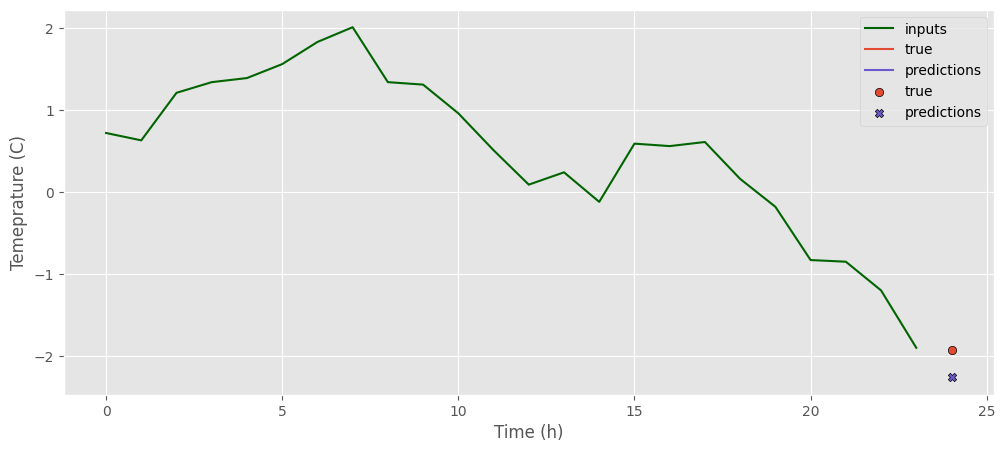

In [32]:
inference = Inference(model, test_data, scaler, in_seq_len=24, out_seq_len=1, offset=24, in_feats=slice(0, 3), out_feats=0, prediction_style='zs')
inference.plot()

In [33]:
test_loss = inference.test_model(test_data, 32, in_feats=slice(0, 3), out_feats=0)
performance_log['miso'].append(test_loss)
print(f'Test Loss : {test_loss}')

Test Loss : 0.00838953722268343


In [34]:
del model

## 4.4 Multi Output

### 4.4.1 Zero-Shot

In [35]:
dataset = CustomDataset(train_data, in_seq_len=24, out_seq_len=24,offset=24, in_features=slice(0,3), out_features=0, scaler = scaler)
print(f'Input shape : {dataset[0][0].shape}\nLabel shape : {dataset[0][1].shape}')

Input shape : torch.Size([24, 3])
Label shape : torch.Size([24, 1])


In [36]:
model = GRUModel(input_features=3, hidden_dim=64, output_features=1, num_layers=1, dropout=0.1, out_seq_len=24)
hx = model._init_state(1)
print(f'prediction shape: {model(dataset[0][0].unsqueeze(0), hx)[0].shape}',
      f'\nlabel shape: {dataset[0][1].unsqueeze(0).shape}')
print(f'num parameters : {sum(p.numel() for p in model.parameters())}')

prediction shape: torch.Size([1, 24, 1]) 
label shape: torch.Size([1, 24, 1])
num parameters : 21697


In [37]:
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [38]:
trainer = Trainer(model, optimizer, dataset, batch_size=64, epochs=10)
trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs : 0 | train loss : 0.3139 | val loss : 0.1533 | gpu usage : 0.0
Epochs : 1 | train loss : 0.1430 | val loss : 0.1366 | gpu usage : 0.0
Epochs : 2 | train loss : 0.1354 | val loss : 0.1267 | gpu usage : 0.0
Epochs : 3 | train loss : 0.1319 | val loss : 0.1273 | gpu usage : 0.0
Epochs : 4 | train loss : 0.1304 | val loss : 0.1294 | gpu usage : 0.0
Epochs : 5 | train loss : 0.1298 | val loss : 0.1255 | gpu usage : 0.0
Epochs : 6 | train loss : 0.1303 | val loss : 0.1285 | gpu usage : 0.0
Epochs : 7 | train loss : 0.1295 | val loss : 0.1254 | gpu usage : 0.0
Epochs : 8 | train loss : 0.1286 | val loss : 0.1278 | gpu usage : 0.0
Epochs : 9 | train loss : 0.1296 | val loss : 0.1287 | gpu usage : 0.0


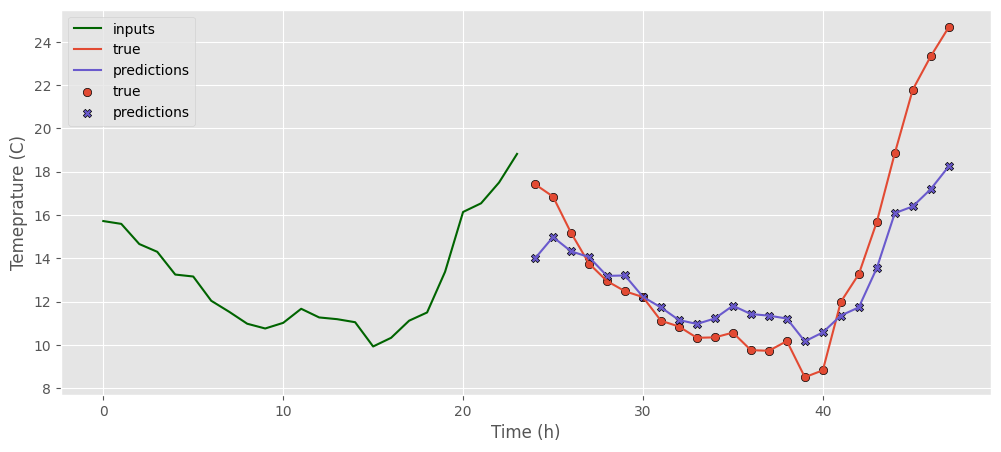

In [39]:
inference = Inference(model, test_data, scaler, in_seq_len=24, out_seq_len=24, offset=24, in_feats=slice(0, 3), out_feats=0, prediction_style='zs')
inference.plot()

In [40]:
test_loss = inference.test_model(test_data, 32, in_feats=slice(0,3), out_feats=0)
performance_log['mimo_zs'].append(test_loss)
print(f'Test Loss : {test_loss}')

Test Loss : 0.14672723412513733


In [41]:
del model

### 4.4.2 AutoRegressive

In [42]:
scaler = StandardScaler()
scaler.fit(train_data, axis=0)

In [43]:
dataset = CustomDataset(train_data, in_seq_len=24, out_seq_len=24, offset=1, in_features=slice(0,3), out_features=slice(0,3), scaler=scaler)
print(f'Input shape : {dataset[0][0].shape}\nLabel shape : {dataset[0][1].shape}')

Input shape : torch.Size([24, 3])
Label shape : torch.Size([24, 3])


In [44]:
model = GRUModel(input_features=3, hidden_dim=64, output_features=3, num_layers=1, dropout=0.3, out_seq_len=24)
hx = model._init_state(1)
print(f'prediction shape: {model(dataset[0][0].unsqueeze(0), hx)[0].shape}',
      f'\nlabel shape: {dataset[0][1].unsqueeze(0).shape}')
print(f'num parameters : {sum(p.numel() for p in model.parameters())}')

prediction shape: torch.Size([1, 24, 3]) 
label shape: torch.Size([1, 24, 3])
num parameters : 21955


In [45]:
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [46]:
trainer = Trainer(model, optimizer, dataset, batch_size=64, epochs=10)
trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs : 0 | train loss : 0.2919 | val loss : 0.0549 | gpu usage : 0.0
Epochs : 1 | train loss : 0.0480 | val loss : 0.0197 | gpu usage : 0.0
Epochs : 2 | train loss : 0.0310 | val loss : 0.0125 | gpu usage : 0.0
Epochs : 3 | train loss : 0.0254 | val loss : 0.0099 | gpu usage : 0.0
Epochs : 4 | train loss : 0.0227 | val loss : 0.0088 | gpu usage : 0.0
Epochs : 5 | train loss : 0.0217 | val loss : 0.0084 | gpu usage : 0.0
Epochs : 6 | train loss : 0.0211 | val loss : 0.0082 | gpu usage : 0.0
Epochs : 7 | train loss : 0.0206 | val loss : 0.0082 | gpu usage : 0.0
Epochs : 8 | train loss : 0.0202 | val loss : 0.0079 | gpu usage : 0.0
Epochs : 9 | train loss : 0.0197 | val loss : 0.0078 | gpu usage : 0.0


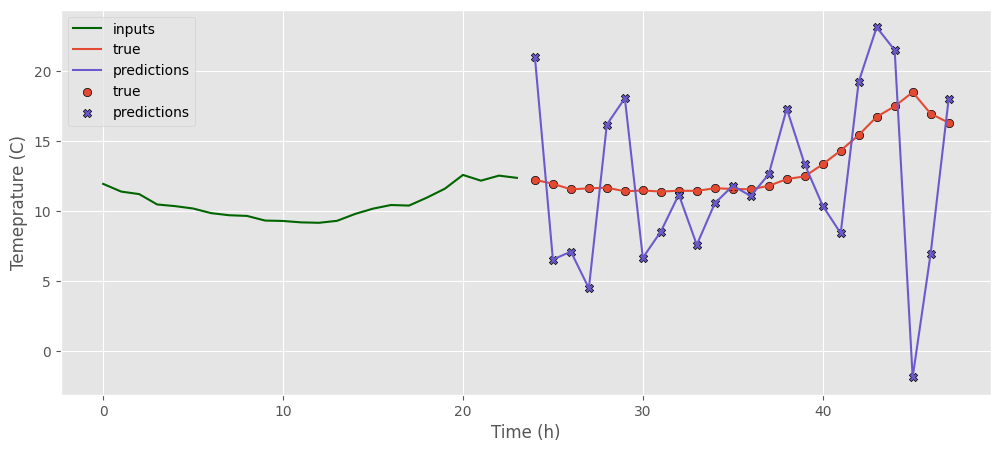

In [47]:
inference = Inference(model, test_data, scaler, in_seq_len=24, out_seq_len=24, offset=1, in_feats=slice(0,3), out_feats=0, prediction_style='ar')
inference.plot()

In [48]:
test_loss = inference.test_model(test_data, 32, in_feats=slice(0,3), out_feats=slice(0,3))
performance_log['mimo_ar'].append(test_loss)
print(f'Test Loss : {test_loss}')

Test Loss : 0.01010421384125948


In [49]:
del model

### 4.4.3 AutoRegressive Classifier

This architecture draws inspiration from LLMs.
- The continuous range is divided into **fixed** number of **classes**.
- **Min-Max scaling** to a **[0, vocab_size]** range is done to discretize the data.
- For multivariate the array/tensor has to be flattened across seq_len and features dimension,i.e increasing seq_len of model by factor of features. (Here univariate forecasting is done).
- Model is trained with cross entropy loss.

#### 4.4.3.1 Min-Max Scaler

In [50]:
class MinMaxScaler:
    def __init__(self, vocab_size:int):
        self.new_min = 0
        self.new_max = vocab_size - 1

    def fit(self, data:np.ndarray, axis:int):
        self.data_min  = np.min(data, axis=axis)
        self.data_max = np.max(data, axis=axis)

    def transform(self, data: np.ndarray) -> np.ndarray:
        data =  (data - self.data_min) / (self.data_max - self.data_min) * (self.new_max - self.new_min) + self.new_min
        return np.round(data).astype(np.int32)

    def inverse_transform(self, scaled_data: np.ndarray) -> np.ndarray:
        return (scaled_data - self.new_min) / (self.new_max - self.new_min) * (self.data_max - self.data_min) + self.data_min

In [51]:
scaler = MinMaxScaler(128)
scaler.fit(train_data[:,0], axis=0)
sc_data = scaler.transform(train_data[:,0])

Data max : 127 
Data min : 0


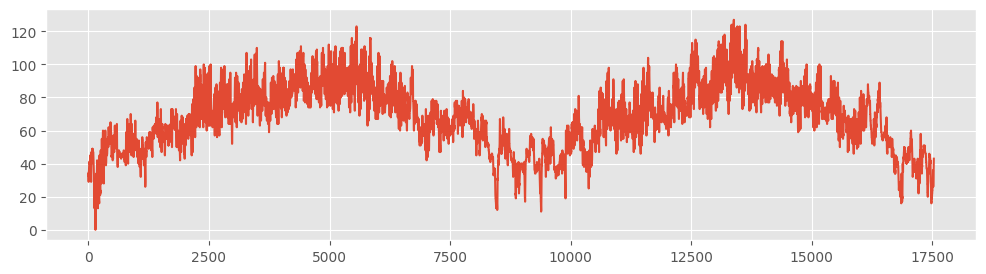

In [52]:
print(f'Data max : {np.max(sc_data)} \nData min : {np.min(sc_data)}')

plt.figure(figsize=(12, 3))
plt.plot(sc_data)
plt.show();

#### 4.3.3.2 Dataset

In [53]:
class CustomDataset(Dataset):
    def __init__(self, data: np.ndarray, in_seq_len: int, out_seq_len: int, offset: int, scaler):
        super().__init__()
        self.data = data
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.offset = offset
        self.scaler = scaler
        self.scaler.fit(data, axis=0)

        if self.in_seq_len > self.offset + self.out_seq_len:
            raise ValueError('Invalid input ouput mapping provided')

    def __len__(self):
        return len(self.data) - self.in_seq_len - self.offset

    def __getitem__(self, index):
        data = self.data[index : index + self.in_seq_len + self.offset]
        data = self.scaler.transform(data)
        x = torch.tensor(data[:self.in_seq_len], dtype=torch.long)
        y = torch.tensor(data[self.offset: self.offset + self.out_seq_len], dtype=torch.long)
        return x, y

dataset = CustomDataset(train_data[:,0], in_seq_len=24, out_seq_len=24, offset=24, scaler=scaler)
print(f'Input shape : {dataset[0][0].shape}\nLabel shape : {dataset[0][1].shape}')

Input shape : torch.Size([24])
Label shape : torch.Size([24])


In [54]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, num_layers: int, dropout: float):
        super(GRUModel, self).__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.ffwd = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        self.lin_out = nn.Linear(hidden_dim, vocab_size)
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

    def forward(self, x, hx):
        if hx.device != x.device:
            hx = hx.to(x.device)
        x = self.emb(x)
        x, hx = self.gru(x, hx)
        x = self.dropout(x)
        x = self.ffwd(x)
        x = self.lin_out(x)
        return x, hx

    def _init_state(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)

model = GRUModel(vocab_size=128, embed_dim=128, hidden_dim=128, num_layers=2, dropout=0.2)
hx = model._init_state(1)
x = torch.randint(0, 128, (1, 24))
print(model(x, hx)[0].shape)
del model

torch.Size([1, 24, 128])


In [55]:
model = GRUModel(vocab_size=128, embed_dim=128, hidden_dim=128, num_layers=2, dropout=0.2)
hx = model._init_state(1)
print(f'prediction shape: {model(dataset[0][0].unsqueeze(0), hx)[0].shape}',
      f'\nlabel shape: {dataset[0][1].unsqueeze(0).shape}')
print(f'num parameters : {sum(p.numel() for p in model.parameters())}')

prediction shape: torch.Size([1, 24, 128]) 
label shape: torch.Size([1, 24])
num parameters : 296960


#### 4.3.3.3 Trainning

In [61]:
class Trainer:
    def __init__(
            self,
            model: nn.Module,
            optimizer: torch.optim.Optimizer,
            dataset: Dataset,
            batch_size: int,
            epochs: int
            ):
        self.model = model
        self.optimizer = optimizer
        self.dataset = dataset
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = next(self.model.parameters()).device

    def get_dataloader(self, split: str):
        train_dataset, val_dataset = random_split(self.dataset, [0.8, 0.2])
        if split == 'train':
            return DataLoader(train_dataset, self.batch_size, True, drop_last=True)
        elif split == 'val':
            return DataLoader(val_dataset, self.batch_size, False, drop_last=True)

    def train_model(self):
        hx = self.model._init_state(self.batch_size)
        loader = self.get_dataloader('train')
        total_loss = []
        self.model.train()
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            y_pred, hx = self.model(x, hx)
            hx = hx.detach()
            loss = F.cross_entropy(y_pred.view(-1, y_pred.shape[-1]), y.view(-1))
            loss.backward()
            self.optimizer.step()
            total_loss.append(loss.detach().cpu().numpy())
        return np.mean(total_loss)

    def eval_model(self):
        loader = self.get_dataloader('val')
        total_loss = []
        self.model.eval()
        hx = self.model._init_state(self.batch_size)
        for x, y in loader:
            with torch.no_grad():
                x, y = x.to(self.device), y.to(self.device)
                self.model.eval()
                y_pred, hx = self.model(x, hx)
                loss = F.cross_entropy(y_pred.view(-1, y_pred.shape[-1]), y.view(-1))
                total_loss.append(loss.detach().cpu().numpy())
        return np.mean(total_loss)

    def train(self):
        for epoch in tqdm(range(self.epochs)):
            train_loss = self.train_model()
            val_loss = self.eval_model()

            if epoch % (self.epochs /10) == 0:
                gpu_usage = round(torch.cuda.memory_reserved(0)/1024**3,1)
                print(f'Epochs : {epoch} | train loss : {train_loss:.4f} | val loss : {val_loss:.4f} | gpu usage : {gpu_usage}')

In [62]:
def save_chkpt(model, optimizer, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def load_chkpt(model, optimizer, path):
    device = next(model.parameters()).device
    chkpt = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(chkpt['model_state_dict'])
    optimizer.load_state_dict(chkpt['optimizer_state_dict'])
    return model, optimizer

In [63]:
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [64]:
#model, optimizer = load_chkpt(model, optimizer, 'temp_emb.pt')

`Note`: GPU is recommended for training this model.

In [65]:
trainer = Trainer(model, optimizer, dataset, batch_size=2048, epochs=1000)
trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs : 0 | train loss : 4.8168 | val loss : 4.7888 | gpu usage : 1.5
Epochs : 100 | train loss : 2.8805 | val loss : 2.7792 | gpu usage : 1.5
Epochs : 200 | train loss : 2.2189 | val loss : 1.9982 | gpu usage : 1.5
Epochs : 300 | train loss : 1.7149 | val loss : 1.4153 | gpu usage : 1.5
Epochs : 400 | train loss : 1.3804 | val loss : 1.0305 | gpu usage : 1.5
Epochs : 500 | train loss : 1.1605 | val loss : 0.8175 | gpu usage : 1.5
Epochs : 600 | train loss : 1.0255 | val loss : 0.7051 | gpu usage : 1.5
Epochs : 700 | train loss : 0.9424 | val loss : 0.6432 | gpu usage : 1.5
Epochs : 800 | train loss : 0.8845 | val loss : 0.6130 | gpu usage : 1.5
Epochs : 900 | train loss : 0.8421 | val loss : 0.5822 | gpu usage : 1.5


In [68]:
save_chkpt(model, optimizer, 'temp_emb.pt')

#### 4.3.3.4 Inference

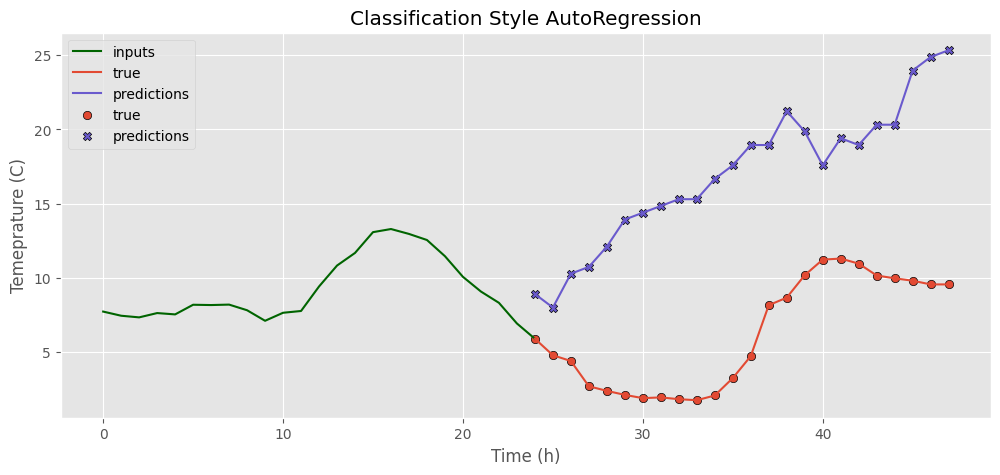

In [69]:
class Inference:
    def __init__(
        self,
        model: nn.Module,
        data: np.ndarray,
        scaler,
        in_seq_len: int,
        out_seq_len: int,
        offset: int,
        prediction_style: str
        ):
        self.model = model
        self.data = data
        self.scaler = scaler
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.offset = offset
        self.prediction_style = prediction_style
        self.device = next(self.model.parameters()).device

    def get_random_sample(self)->torch.Tensor:
        self.idx = np.random.randint(len(self.data) - self.in_seq_len - self.offset)
        x = self.data[self.idx : self.idx + self.in_seq_len]
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype = torch.long, device = self.device)
        if x.ndim == 1:
            x = x.view(1, -1)
        return x

    def ar_generation(self, x:torch.Tensor)->np.ndarray:
        hx = self.model._init_state(x.shape[0])
        self.model.eval()
        with torch.inference_mode():
            for _ in range(self.out_seq_len):
                x_trunc = x[:, -self.out_seq_len:]
                y_pred, hx = self.model(x_trunc, hx)
                y_pred = F.softmax(y_pred[:,-1,:], dim=-1)
                y_pred = torch.argmax(y_pred, dim=-1)
                x = torch.cat((x_trunc, y_pred.view(1,-1)), dim=1)
        return x[:,-self.out_seq_len:].cpu().detach().numpy()


    def predict(self)->np.ndarray:
        x = self.get_random_sample()
        y_pred = self.ar_generation(x)
        y_pred = self.scaler.inverse_transform(y_pred).reshape(-1)
        return y_pred

    def plot(self):
        y_pred = self.predict()
        x = self.data[self.idx : self.idx + self.in_seq_len+1]
        y = self.data[self.idx + self.in_seq_len : self.idx + self.in_seq_len + self.out_seq_len]

        plt.figure(figsize=(12, 5))
        plt.plot(range(0, self.in_seq_len+1), x, label='inputs', color='darkgreen')
        plt.plot(range(self.in_seq_len, self.in_seq_len+ self.out_seq_len), y, label = 'true')
        plt.plot(range(self.in_seq_len, self.in_seq_len + self.out_seq_len), y_pred, color='slateblue', label ='predictions')
        plt.scatter(range(self.in_seq_len, self.in_seq_len+ self.out_seq_len), y, edgecolors='black', label = 'true')
        plt.scatter(range(self.in_seq_len, self.in_seq_len + self.out_seq_len), y_pred, marker='X', edgecolors='black', color='slateblue', label ='predictions')
        plt.legend()
        plt.xlabel('Time (h)')
        plt.ylabel('Temeprature (C)')
        plt.title('Classification Style AutoRegression')
        plt.show()

    def test_model(self, data:np.ndarray, batch_size:int)->np.ndarray:
        self.scaler.fit(data, axis=0)
        dataset = CustomDataset(data, self.in_seq_len, self.out_seq_len, self.offset, self.scaler)
        dataloader = DataLoader(dataset, batch_size, drop_last=True)
        total_loss = []
        hx = self.model._init_state(batch_size)
        self.model.eval()
        with torch.inference_mode():
            for x, y in dataloader:
                x, y = x.to(self.device), y.to(self.device)
                y_pred , hx = self.model(x, hx)
                loss = F.cross_entropy(y_pred.view(-1, y_pred.shape[-1]), y.view(-1))
                total_loss.append(loss.cpu().detach().numpy())
        return np.mean(total_loss)

inference = Inference(model, test_data[:,0], scaler, in_seq_len=24, out_seq_len=24, offset=1, prediction_style='ar')
inference.plot()

`Note`: Autoregressive model in the form of classification has to been trained longer to get good results and therefore is not compared.

# 5.0 Comparing Models

**Abbreviation guide:**
- siso : single input single output.
- miso : multiple input single output.
- mimo_zs : multiple input multiple output with zero shot prediction.
- mimio_ar : multiple input multiple output with autoregressive prediction.

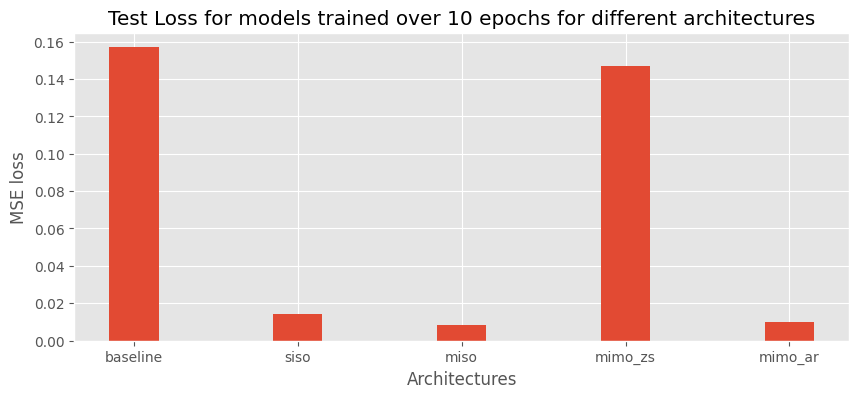

In [71]:
plt.figure(figsize=(10, 4))
plt.bar(list(performance_log.keys()), sum(list(performance_log.values()), []), width=0.3)
plt.title('Test Loss for models trained over 10 epochs for different architectures')
plt.xlabel('Architectures')
plt.ylabel('MSE loss')
plt.show();